In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numbers

from functools import partial
from threading import Thread
from tornado import gen

from PIL import Image

from tpot import TPOTClassifier

import os
from tqdm import tqdm_notebook as tqdm

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
import seaborn as sns
from pylab import rcParams

%matplotlib inline 
plt.style.use('seaborn')
sns.set(style='whitegrid',color_codes=True)

# classifiaction 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import catboost as ctb

# for classification
from sklearn.metrics import accuracy_score

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Hp optimization imports
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import mlflow

import re
import eli5
import gc
import random    
import math
import psutil
import pickle
import datetime
from time import time

# save/load models
from joblib import dump
from joblib import load

import timeit 



/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/eli5/base_utils.py:36: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  return attr.s(class_, these=these, init=False, slots=True, **attrs_kwargs)  # type: ignore
Using TensorFlow backend.
/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/botocore/awsrequest.py:624: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class HeadersDict(collections.MutableMapping):


In [2]:
root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
models_root = "../../models/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('max_columns', 150)
# rcParams['figure.figsize'] = 16,8

In [3]:
%%time
train_df = pd.read_csv(root + "Train_File.csv")
test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

CPU times: user 2.97 s, sys: 442 ms, total: 3.41 s
Wall time: 3.43 s


In [4]:
def create_lags(df):
    for i in range(0, 25):
        df["lag_forward_{}".format(i)] = df.GR.shift(i)
        df["lag_backward_{}".format(i)] = df.GR.shift(-i)
    return df

In [5]:
train_df_ts = train_df[train_df["well_id"] < 100]
train_df_ts = train_df_ts.groupby("well_id").apply(create_lags)
train_df_ts = train_df_ts.fillna(0)

valid_df_ts = train_df[train_df["well_id"].isin(list(range(100,120)))]
valid_df_ts = valid_df_ts.groupby("well_id").apply(create_lags)
valid_df_ts = valid_df_ts.fillna(0)


In [6]:
class GLFTP_lag_data(Dataset):
    
    def __init__(self, df):
        
        scaler = StandardScaler()
        if 'label' not in df.columns:
            X = df
        else:
            X = df.drop(['label'], axis=1)
           
        scaler.fit(X)
        X = scaler.transform(X)
        
        if 'label' not in df.columns:
            # test data
            self.X = torch.from_numpy(X[:,:,None])
            self.y = None
        else:
            # training data
            self.X = torch.from_numpy(X[:,:,None])
            self.y = torch.from_numpy(df['label'].values)
    
        
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]


In [7]:
batch_size = 64

train_dataset = GLFTP_lag_data(train_df_ts)
valid_dataset = GLFTP_lag_data(valid_df_ts)
# test_dataset = MNIST_data(test_df)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
def show_batch(loader, lb=True):
    batcher = iter(loader)
    if lb:
        data, labels = batcher.next()
    else:
        data = batcher.next()
    print(len(loader))
    print(len(data))
    print(data)
    if lb:
        print(labels)

In [9]:
# show_batch(train_loader, lb=True)

In [10]:
def train(model, train_loader):
    batch_loss = 0.0
    batch_corrects = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
#         outputs = model(inputs)
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.max(outputs, 1)[1]
        batch_loss += loss.item()
        batch_corrects += torch.sum(preds == labels.data)
    
    return batch_loss/len(train_loader), batch_corrects.float()/len(train_dataset)

In [11]:
def evaluate(model, valid_loader):
    loss = 0.0
    corrects = 0.0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = Variable(inputs), Variable(labels)
#             outputs = model(inputs)
            outputs = model(inputs.float())
            loss += F.cross_entropy(outputs, labels, reduction='mean').item()
            pred = outputs.data.max(1, keepdim=True)[1]
            corrects += pred.eq(labels.data.view_as(pred)).cpu().sum()
               
    return loss/len(valid_loader), corrects.float()/len(valid_dataset)

In [12]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.full_conn_layers = nn.Sequential(
            nn.Linear(53, 200),        
            nn.ReLU(inplace=True),
#             nn.Linear(128, 64),
#             nn.ReLU(),
            nn.Linear(200, 10)         
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

In [13]:
model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

In [14]:
def experiment(model, epochs, criterion, optimizer, scheduler):
    epoch_loss_history = []
    epoch_corrects_history = []
    val_loss_history = []
    val_corrects_history = []

    for epoch in range(epochs):
        epoch_loss, epoch_corrects = train(model, train_loader)
        val_loss, val_corrects = evaluate(model, valid_loader)

        epoch_loss_history.append(epoch_loss)
        epoch_corrects_history.append(epoch_corrects)
        val_loss_history.append(val_loss)
        val_corrects_history.append(val_corrects)

        print('epoch:', (epoch+1))
        print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_corrects.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))
        scheduler.step(val_corrects)
        
    return epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history

In [15]:
def show_histori():
    plt.plot(epoch_loss_history, label='training loss')
    plt.plot(val_loss_history, label='validation loss')
    plt.legend()
    plt.show()
    
    plt.plot(epoch_corrects_history, label='training accuracy')
    plt.plot(val_corrects_history, label='validation accuracy')
    plt.legend()
    plt.show()

epoch: 1
training loss: 1.1416, training acc 0.6365 
validation loss: 1.0242, validation acc 0.6886 
epoch: 2
training loss: 0.8259, training acc 0.7118 
validation loss: 0.8030, validation acc 0.7541 
epoch: 3
training loss: 0.7480, training acc 0.7436 
validation loss: 0.6684, validation acc 0.7914 
epoch: 4
training loss: 0.7010, training acc 0.7626 
validation loss: 0.6232, validation acc 0.8013 
epoch: 5
training loss: 0.6521, training acc 0.7735 
validation loss: 0.6542, validation acc 0.7892 
epoch: 6
training loss: 0.6372, training acc 0.7816 
validation loss: 0.5990, validation acc 0.8075 
epoch: 7
training loss: 0.6156, training acc 0.7886 
validation loss: 0.6139, validation acc 0.7974 
epoch: 8
training loss: 0.6138, training acc 0.7905 
validation loss: 0.5868, validation acc 0.8157 
epoch: 9
training loss: 0.5998, training acc 0.7957 
validation loss: 0.5657, validation acc 0.8220 
epoch: 10
training loss: 0.5967, training acc 0.7975 
validation loss: 0.5625, validation a

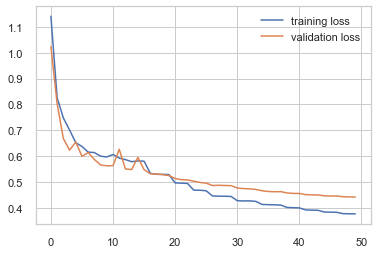

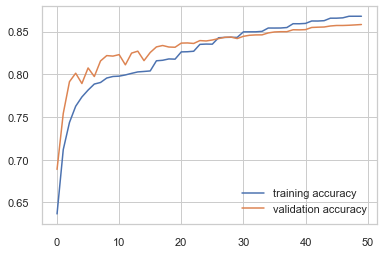

CPU times: user 13min 55s, sys: 49 s, total: 14min 44s
Wall time: 2min 25s


In [17]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.full_conn_layers = nn.Sequential(
            nn.Linear(53, 200),        
            nn.ReLU(inplace=True),
            nn.Linear(200, 5)         
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

epoch: 1
training loss: 1.2540, training acc 0.5144 
validation loss: 1.1279, validation acc 0.5355 
epoch: 2
training loss: 1.1286, training acc 0.5261 
validation loss: 0.9838, validation acc 0.5718 
epoch: 3
training loss: 1.0846, training acc 0.5535 
validation loss: 0.9233, validation acc 0.6147 
epoch: 4
training loss: 1.0223, training acc 0.5619 
validation loss: 0.9413, validation acc 0.6146 
epoch: 5
training loss: 1.2484, training acc 0.5666 
validation loss: 1.1209, validation acc 0.5504 
Epoch     4: reducing learning rate of group 0 to 8.0000e-03.
epoch: 6
training loss: 1.0496, training acc 0.5607 
validation loss: 0.8992, validation acc 0.6159 
epoch: 7
training loss: 0.9738, training acc 0.5886 
validation loss: 0.8814, validation acc 0.6263 
epoch: 8
training loss: 0.9669, training acc 0.5960 
validation loss: 0.9160, validation acc 0.6352 
epoch: 9
training loss: 0.9876, training acc 0.5893 
validation loss: 0.8759, validation acc 0.6302 
epoch: 10
training loss: 0.93

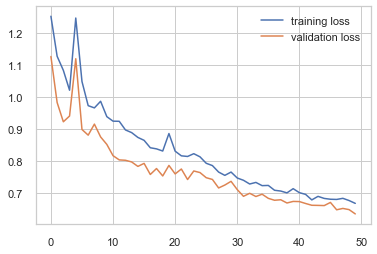

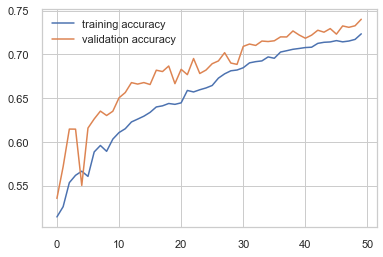

CPU times: user 45min 26s, sys: 1min 29s, total: 46min 55s
Wall time: 7min 24s


In [19]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.full_conn_layers = nn.Sequential(
            nn.Linear(53, 512),        
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(512, 248),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(248, 5),      
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

In [ ]:
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model


def get_base_model(input_len, fsize):
    #this base model is one branch of the main model
    #it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
    #the input is a time series of length n and width 19
    input_seq = Input(shape=(input_len, 19))
    #choose the number of convolution filters
    nb_filters = 10
    #1-D convolution and global max-pooling
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #dense layer with dropout regularization
    compressed = Dense(50, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model



def main_model(inputs_lens = [512, 1024, 3480], fsizes = [8,16,24]):
    #this is the main model
    #it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = Input(shape=(inputs_lens[0], 19))
    input_medseq = Input(shape=(inputs_lens[1] , 19))
    input_origseq = Input(shape=(inputs_lens[2], 19))
    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])
    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    #concatenate all the outputs
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    out = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    return model


In [ ]:
%%time

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

epoch: 1
training loss: 1.5603, training acc 0.5819 
validation loss: 1.8493, validation acc 0.6325 
epoch: 2
training loss: 1.2138, training acc 0.6147 
validation loss: 1.5925, validation acc 0.6725 
epoch: 3
training loss: 1.1133, training acc 0.6209 
validation loss: 1.2593, validation acc 0.6785 
epoch: 4
training loss: 0.9792, training acc 0.6461 
validation loss: 1.1563, validation acc 0.7033 
epoch: 5
training loss: 0.9972, training acc 0.6636 
validation loss: 1.1562, validation acc 0.7133 
epoch: 6
training loss: 0.9315, training acc 0.6719 
validation loss: 0.9481, validation acc 0.6884 
epoch: 7
training loss: 0.9186, training acc 0.6827 
validation loss: 1.1098, validation acc 0.7178 
epoch: 8
training loss: 0.8550, training acc 0.6970 
validation loss: 0.9473, validation acc 0.7385 
epoch: 9
training loss: 0.8552, training acc 0.7095 
validation loss: 0.8462, validation acc 0.7480 
epoch: 10
training loss: 0.7836, training acc 0.7282 
validation loss: 0.7426, validation a

In [ ]:
plt.plot(epoch_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

In [ ]:
plt.plot(epoch_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()

In [112]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.full_conn_layers = nn.Sequential(
            nn.Linear(53, 128),        
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)         
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

epoch: 1
training loss: 1.1408, training acc 0.5918 
validation loss: 0.9308, validation acc 0.6460 
epoch: 2
training loss: 0.9683, training acc 0.6165 
validation loss: 0.8947, validation acc 0.6671 
epoch: 3
training loss: 0.9341, training acc 0.6170 
validation loss: 0.9695, validation acc 0.6544 
epoch: 4
training loss: 0.9208, training acc 0.6325 
validation loss: 0.8256, validation acc 0.6764 
epoch: 5
training loss: 0.8757, training acc 0.6474 
validation loss: 0.8346, validation acc 0.6553 
epoch: 6
training loss: 0.8235, training acc 0.6531 
validation loss: 0.7946, validation acc 0.7224 
epoch: 7
training loss: 0.8021, training acc 0.6582 
validation loss: 0.7487, validation acc 0.7264 
epoch: 8
training loss: 0.8316, training acc 0.6590 
validation loss: 0.7622, validation acc 0.7091 
epoch: 9
training loss: 0.8005, training acc 0.6799 
validation loss: 0.6700, validation acc 0.7465 
epoch: 10
training loss: 0.7137, training acc 0.7124 
validation loss: 0.6795, validation a

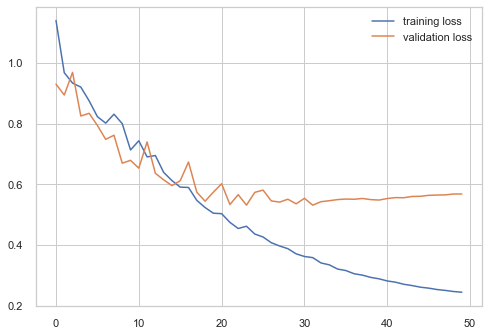

In [113]:
plt.plot(epoch_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

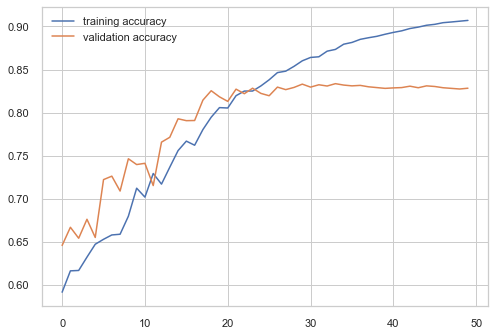

In [114]:
plt.plot(epoch_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()

In [116]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.full_conn_layers = nn.Sequential(
            nn.Linear(53, 128),    
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)         
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

epoch: 1
training loss: 1.4307, training acc 0.4917 
validation loss: 1.1367, validation acc 0.6309 
epoch: 2
training loss: 1.2561, training acc 0.5462 
validation loss: 1.0651, validation acc 0.6342 
epoch: 3
training loss: 1.1313, training acc 0.5832 
validation loss: 1.0151, validation acc 0.6404 
epoch: 4
training loss: 1.0370, training acc 0.6128 
validation loss: 0.9871, validation acc 0.6422 
epoch: 5
training loss: 0.9645, training acc 0.6358 
validation loss: 0.9826, validation acc 0.6384 
epoch: 6
training loss: 0.9063, training acc 0.6550 
validation loss: 0.9691, validation acc 0.6389 
Epoch     5: reducing learning rate of group 0 to 8.0000e-03.
epoch: 7
training loss: 0.8254, training acc 0.6854 
validation loss: 0.9526, validation acc 0.6245 
epoch: 8
training loss: 0.7798, training acc 0.7021 
validation loss: 0.9428, validation acc 0.6145 
Epoch     7: reducing learning rate of group 0 to 6.4000e-03.
epoch: 9
training loss: 0.7136, training acc 0.7282 
validation loss

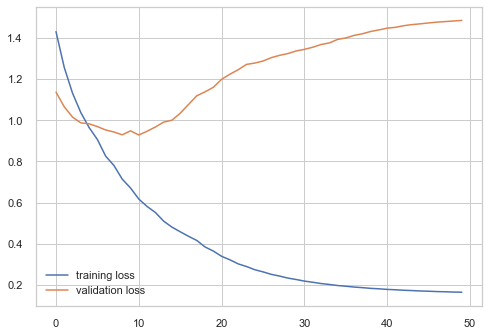

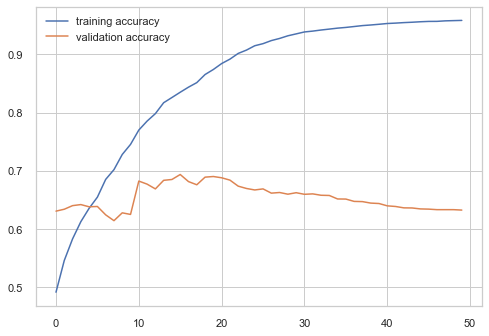

epoch: 1
training loss: 1.1689, training acc 0.5648 
validation loss: 0.9743, validation acc 0.6493 
epoch: 2
training loss: 1.0309, training acc 0.6053 
validation loss: 0.9646, validation acc 0.6507 
epoch: 3
training loss: 0.9605, training acc 0.6269 
validation loss: 0.9177, validation acc 0.6573 
epoch: 4
training loss: 0.9629, training acc 0.6191 
validation loss: 0.8775, validation acc 0.6415 
epoch: 5
training loss: 0.8948, training acc 0.6419 
validation loss: 0.8563, validation acc 0.6691 
epoch: 6
training loss: 0.8496, training acc 0.6604 
validation loss: 0.8054, validation acc 0.6633 
epoch: 7
training loss: 0.8657, training acc 0.6545 
validation loss: 0.9226, validation acc 0.6645 
Epoch     6: reducing learning rate of group 0 to 8.0000e-03.
epoch: 8
training loss: 0.8334, training acc 0.6494 
validation loss: 0.8244, validation acc 0.6767 
epoch: 9
training loss: 0.7758, training acc 0.6918 
validation loss: 0.7678, validation acc 0.7111 
epoch: 10
training loss: 0.75

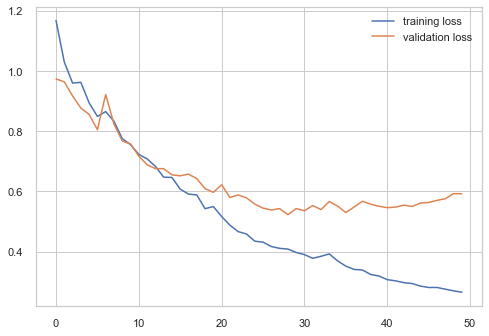

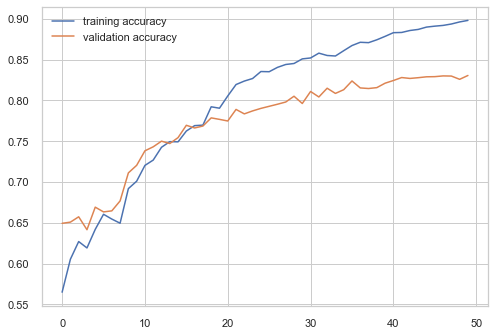

CPU times: user 2min 49s, sys: 21.4 s, total: 3min 11s
Wall time: 1min 49s


In [129]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(53, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.ReLU(),
#             nn.Conv1d(128, 1024, 1)
        )
        self.full_conn_layers = nn.Sequential(
#             nn.Linear(1024, 128),    
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
            nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)         
        )
    
    def forward(self, x):
#         x = x.view(x.size(0), -1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

epoch: 1
training loss: 1.3587, training acc 0.4669 
validation loss: 2.2732, validation acc 0.5036 
epoch: 2
training loss: 1.0969, training acc 0.5687 
validation loss: 1.0620, validation acc 0.5947 
epoch: 3
training loss: 1.0027, training acc 0.5877 
validation loss: 0.9206, validation acc 0.6367 
epoch: 4
training loss: 1.0987, training acc 0.5987 
validation loss: 1.0719, validation acc 0.6344 
epoch: 5
training loss: 1.1118, training acc 0.5927 
validation loss: 1.1136, validation acc 0.6302 
Epoch     4: reducing learning rate of group 0 to 8.0000e-03.
epoch: 6
training loss: 0.9469, training acc 0.6110 
validation loss: 0.9176, validation acc 0.6425 
epoch: 7
training loss: 0.9405, training acc 0.6202 
validation loss: 0.8771, validation acc 0.6469 
epoch: 8
training loss: 0.8820, training acc 0.6267 
validation loss: 0.8541, validation acc 0.6467 
epoch: 9
training loss: 0.8450, training acc 0.6346 
validation loss: 0.8267, validation acc 0.6484 
epoch: 10
training loss: 0.84

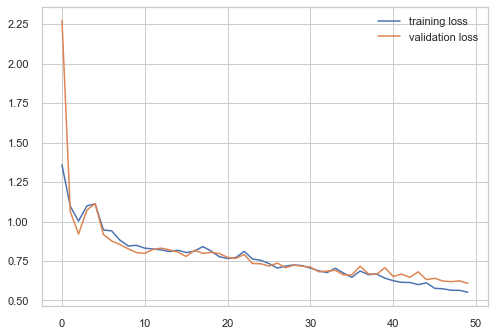

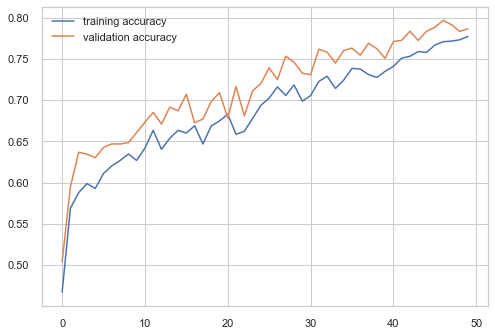

CPU times: user 9min 7s, sys: 58 s, total: 10min 5s
Wall time: 2min 43s


In [132]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(53, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
#             nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128*2, 1),
#             nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(128*2, 128),    
#             nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)         
        )
    
    def forward(self, x):
#         x = x.view(x.size(0), -1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

epoch: 1
training loss: 1.4053, training acc 0.4974 
validation loss: 1.2229, validation acc 0.5102 
epoch: 2
training loss: 1.1222, training acc 0.5668 
validation loss: 1.0931, validation acc 0.6269 
epoch: 3
training loss: 1.0355, training acc 0.5818 
validation loss: 1.0586, validation acc 0.6407 
epoch: 4
training loss: 0.9716, training acc 0.5972 
validation loss: 0.9834, validation acc 0.6607 
epoch: 5
training loss: 0.9353, training acc 0.6081 
validation loss: 0.9240, validation acc 0.6669 
epoch: 6
training loss: 0.9142, training acc 0.6188 
validation loss: 0.9282, validation acc 0.6613 
epoch: 7
training loss: 0.8858, training acc 0.6310 
validation loss: 0.9994, validation acc 0.6609 
Epoch     6: reducing learning rate of group 0 to 8.0000e-03.
epoch: 8
training loss: 0.8571, training acc 0.6475 
validation loss: 0.9005, validation acc 0.6685 
epoch: 9
training loss: 0.8190, training acc 0.6581 
validation loss: 0.8459, validation acc 0.6995 
epoch: 10
training loss: 0.80

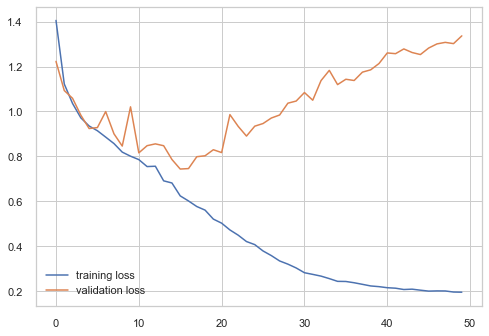

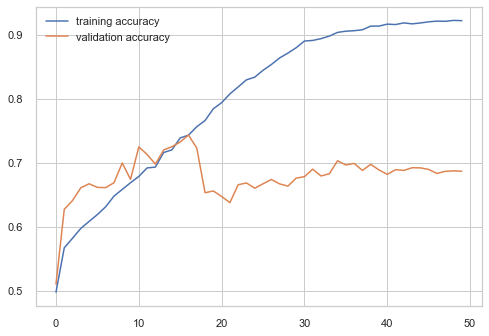

CPU times: user 8min 7s, sys: 39.3 s, total: 8min 46s
Wall time: 6min 24s


In [137]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(53, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(256, 128),    
#             nn.BatchNorm1d(128),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(64, 10)         
        )
    
    def forward(self, x):
#         x = x.view(x.size(0), -1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.LSTM(100, input_shape=(n_timesteps,n_features)),
            nn.Dropout(0.3),
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(256, 128),    
#             nn.BatchNorm1d(128),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(64, 10)         
        )
    
    def forward(self, x):
#         x = x.view(x.size(0), -1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

model = SimpleNet()
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.8,
    min_lr=1e-6,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

epoch_loss_history, epoch_corrects_history, val_loss_history, val_corrects_history = experiment(model, epochs, criterion, optimizer, scheduler)

show_histori()

In [138]:
lstm = nn.LSTM(3, 3)

In [139]:
lstm

LSTM(3, 3)

In [140]:
inputs = [torch.randn(1, 3) for _ in range(5)]

In [141]:
inputs

[tensor([[ 0.6787,  0.0329, -1.0496]]),
 tensor([[ 0.9424, -1.3602,  1.5842]]),
 tensor([[-0.7562,  1.3077,  0.1756]]),
 tensor([[-1.0960, -0.4902, -1.1209]]),
 tensor([[ 0.4033, -0.5696,  0.1820]])]

In [142]:
# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))

In [143]:
hidden

(tensor([[[ 0.7560, -0.4104,  0.7609]]]),
 tensor([[[ 1.0621,  0.6524, -1.6103]]]))

In [144]:
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)